### Import standard modules


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

### Initialize standard logger

In [2]:
import logging

logging.basicConfig(format="%(asctime)s.%(msecs)03d %(levelname)-8s %(message)s",
                    datefmt="%Y-%m-%d %H:%M:%S",
                    level=logging.INFO)

### Create the Simulation State

There are 2 objects that hold the state of the simulation:
  1. *Population* is a container for the state each persion
  2. *Society* is the state of the government, eg the testing processes

In [3]:
from codit.society import Society
from codit.population.covid import PersonCovid
from codit.population.networks.city import CityPopulation
from codit.population.networks.city_config.city_cfg import city_paras
from codit.society.alternatives import UKSociety

/home/paul/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# For now set a small population for Leeds (down by a factor of 20):

#### TODO: delete this box

In [4]:
POPULATION_SIZE = city_paras["Leeds"]['population'] // 20

In [5]:
# Most classrooms and workplaces are closed
LOCKDOWN_CFG = dict(classrooms=0.66, workplaces=0.66, ephemeral_contact=0.0)

# We assume that Covid survivors, and the vaccinated, have an 80% chance of catching and passing on the disease another time:
X_IMMUNITY=0.8
# However this factor is square for the indian variant (and 80% squared is 64%)

pop = CityPopulation(POPULATION_SIZE, Society(config=dict(X_IMMUNITY=X_IMMUNITY)), 
                     person_type=PersonCovid, lockdown_config=LOCKDOWN_CFG)

SOCIETY_CFG = dict(DAILY_TEST_CAPACITY_PER_HEAD=0.01, 
                            PROB_APPLY_FOR_TEST_IF_SYMPTOMS=0.33)

soc = UKSociety(config=SOCIETY_CFG)

2021-05-16 20:42:52.479 INFO     Building a set of 15862 households from which to build a population
2021-05-16 20:42:56.686 INFO     15294 households of mean size 2.59
2021-05-16 20:42:56.873 INFO     8306 buildings of mean size 4.77
2021-05-16 20:42:58.325 INFO     231 classrooms of mean size 13.50
2021-05-16 20:42:58.338 INFO     7 care_homes of mean size 104.43
2021-05-16 20:42:58.369 INFO     4608 workplaces of mean size 5.65
2021-05-16 20:42:58.494 INFO     66.0% of workplaces closed by lockdown, leaving 1575 open, of average Income Decile 4.94 (and st dev 3.15).
2021-05-16 20:42:58.503 INFO     66.0% of classrooms closed by lockdown, leaving 90 open, of average Income Decile 4.22 (and st dev 3.00).
2021-05-16 20:42:58.505 INFO     Adding 16966 permanent contact groups
2021-05-16 20:42:58.505 INFO     Adding 0 ephemeral contact pairs
2021-05-16 20:42:58.722 INFO     Adding 11386 contacts each within one of the 8306 buildings (contact density of 0.75)


### Create the 2 variants

In [6]:
from codit.disease import Covid
from codit.immunity import ImmuneResponse

kent_variant = Covid(variant=ImmuneResponse.B_1_1_7_INFECTION)
indian_variant = Covid(variant=ImmuneResponse.B_1_617_2_INFECTION)

### Burn in the simulation

In [7]:
from codit.outbreak import Outbreak

BURNIN_DAYS = 30
WINTER_PREVALENCE = 1/40
SEED_SIZE = int(POPULATION_SIZE * WINTER_PREVALENCE)

o_burnin = Outbreak(soc, kent_variant, n_days=BURNIN_DAYS, seed_size=SEED_SIZE, population=pop)
o_burnin.simulate()

2021-05-16 20:43:00.221 INFO     Day 1, prop infected is 0.03, prop infectious is 0.0182
2021-05-16 20:43:12.068 INFO     Day 30, prop infected is 0.12, prop infectious is 0.0156


### Run the simulation for January and February

2021-05-16 20:43:13.849 INFO     Day 1, prop infected is 0.12, prop infectious is 0.0144
2021-05-16 20:43:32.221 INFO     Day 51, prop infected is 0.15, prop infectious is 0.0027
2021-05-16 20:43:35.171 INFO     Day 60, prop infected is 0.15, prop infectious is 0.0018
2021-05-16 20:43:35.351 INFO      Realized R0 of early infections is 0.90
2021-05-16 20:43:35.352 INFO      15.5 percent of the population was infected during the epidemic


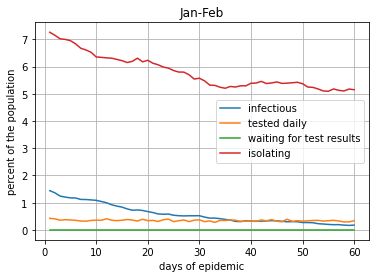

In [8]:
from codit.outbreak_recorder import WardComponent

DAYS_MONTH = 30

o_Jan_Feb = Outbreak(soc, n_days=DAYS_MONTH * 2, population=pop, reset_population=False)
o_Jan_Feb.recorder.add_component(WardComponent(o_Jan_Feb))
o_Jan_Feb.simulate()
o_Jan_Feb.recorder.plot(title="Jan-Feb")

### March 
  1. Open classrooms
  2. People now 'brush past' on average 0.3 others randomly per day (see COMIX)
  3. Vaccinate the over 60s

In [9]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.66, ephemeral_contact=0.3)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if p.age > 60 and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-16 20:43:35.677 INFO     66.0% of workplaces closed by lockdown, leaving 1630 open, of average Income Decile 4.97 (and st dev 3.15).
2021-05-16 20:43:35.687 INFO     0.0% of classrooms closed by lockdown, leaving 195 open, of average Income Decile 4.71 (and st dev 3.07).
2021-05-16 20:43:35.689 INFO     Adding 17126 permanent contact groups
2021-05-16 20:43:35.697 INFO     Adding 5947 ephemeral contact pairs
2021-05-16 20:43:35.746 INFO     Adding 11414 contacts each within one of the 8306 buildings (contact density of 0.75)


2021-05-16 20:43:37.633 INFO     Day 1, prop infected is 0.15, prop infectious is 0.0018
2021-05-16 20:43:47.247 INFO     Day 30, prop infected is 0.16, prop infectious is 0.0009
2021-05-16 20:43:47.396 INFO      Realized R0 of early infections is 0.93
2021-05-16 20:43:47.397 INFO      15.8 percent of the population was infected during the epidemic


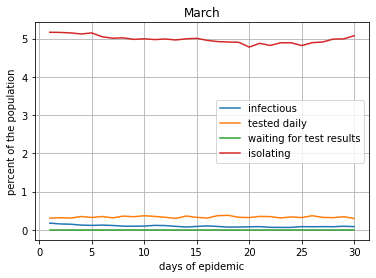

In [10]:
o_March = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_March.recorder.add_component(WardComponent(o_March))
o_March.simulate()
o_March.recorder.plot(title="March")

### April
    1. More workplaces (such as non-essential retail) open up
    2. More people brush past each other as restrictions are lifted
    3. 10 people introduce the Indian variant into the Leeds population
    4. Vaccinate the over 50s

In [11]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.5, ephemeral_contact=0.4)

pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

pop.seed_infections(10, indian_variant)
pop.clear_memory()

for i, p in enumerate(pop.people):
    if (60 >= p.age > 50) and i % 20: # vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-16 20:43:47.717 INFO     50.0% of workplaces closed by lockdown, leaving 2364 open, of average Income Decile 4.91 (and st dev 3.14).
2021-05-16 20:43:47.728 INFO     0.0% of classrooms closed by lockdown, leaving 186 open, of average Income Decile 4.61 (and st dev 3.04).
2021-05-16 20:43:47.729 INFO     Adding 17851 permanent contact groups
2021-05-16 20:43:47.741 INFO     Adding 7930 ephemeral contact pairs
2021-05-16 20:43:47.788 INFO     Adding 11420 contacts each within one of the 8306 buildings (contact density of 0.75)


2021-05-16 20:43:49.846 INFO     Day 1, prop infected is 0.16, prop infectious is 0.0011
2021-05-16 20:43:59.741 INFO     Day 30, prop infected is 0.16, prop infectious is 0.0016
2021-05-16 20:43:59.898 INFO      Realized R0 of early infections is 1.04
2021-05-16 20:43:59.899 INFO      16.5 percent of the population was infected during the epidemic


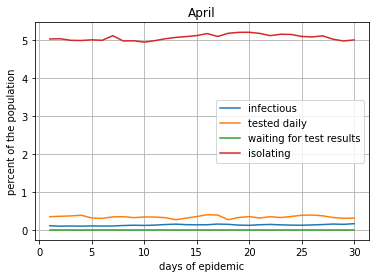

In [12]:
o_April = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_April.recorder.add_component(WardComponent(o_April))
o_April.simulate()
o_April.recorder.plot(title="April")

### May
    1. Even more workplaces open up
    2. More people brush past on average 0.5 others randomly per day


In [13]:
LOCKDOWN_CFG = dict(classrooms=0.0, workplaces=0.33, ephemeral_contact=0.5)
pop.clear_memory()
pop.set_structure(soc, lockdown_config=LOCKDOWN_CFG)

for i, p in enumerate(pop.people):
    if (50 >= p.age > 45) and i % 20: # we vaccinate 19 in every 20 people
        p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-16 20:44:00.245 INFO     33.0% of workplaces closed by lockdown, leaving 3002 open, of average Income Decile 4.93 (and st dev 3.13).
2021-05-16 20:44:00.257 INFO     0.0% of classrooms closed by lockdown, leaving 196 open, of average Income Decile 4.70 (and st dev 3.07).
2021-05-16 20:44:00.258 INFO     Adding 18499 permanent contact groups
2021-05-16 20:44:00.301 INFO     Adding 9914 ephemeral contact pairs
2021-05-16 20:44:00.347 INFO     Adding 11432 contacts each within one of the 8306 buildings (contact density of 0.75)


### Surge Vaccinations all people over 16?

In [14]:
# for p in pop.people:
#     if p.age > 16:
#         p.vaccinate_with(ImmuneResponse.ASTRAZENECA_1ST_DOSE)

2021-05-16 20:44:02.555 INFO     Day 1, prop infected is 0.16, prop infectious is 0.0015
2021-05-16 20:44:12.469 INFO     Day 30, prop infected is 0.17, prop infectious is 0.0014
2021-05-16 20:44:12.619 INFO      Realized R0 of early infections is 1.15
2021-05-16 20:44:12.620 INFO      17.0 percent of the population was infected during the epidemic


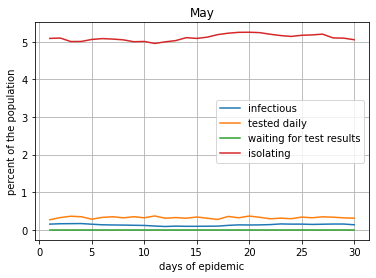

In [15]:
o_May = Outbreak(soc, n_days=DAYS_MONTH, population=pop, reset_population=False)
o_May.recorder.add_component(WardComponent(o_May))
o_May.simulate()
o_May.recorder.plot(title="May")